In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.metrics as skm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline

In [2]:
df_iad = pd.read_csv("../data/classification/final_IADSED.csv")
df_emo = pd.read_csv("../data/classification/final_EmoSounds.csv")

In [3]:
"""
  Load target features on y and drop target features on X.
  Perform shuffle on first split to prevent bias. Split 80-20 for train-test.
  Split again on train to get validation set. So 60-20-20.
"""
def train_test_valid_split(df, targets):
  y = df[targets]
  X = df.drop(targets, axis=1)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state=101)

  return X_train, X_test, X_val, y_train, y_test, y_val

In [ ]:
"""
  Creates random forest classifer instance with default hyperparameters.
  If classifer_cv is provided, then use the best hyperparameters from grid search results.
  
  If asked to do dataset balancing, train a Balanced Random Forest Classifer by drawing a sample from minority class and
  sample with replacement the same number of samples from majority class.

  If asked to do grid search and parameter grid is provided, then we will perform grid search to find the best parameters. 
  After grid search is complete, print the best parameters.

  Otherwise, train the model with our training data.
"""
def RFClassifer(X_train, y_train, grid_search=False, param_grid=None, classifer_cv=None, ds_balancing=False, ds_name="NA"):

  if ds_balancing == True:
    if classifer_cv == None:
      classifer = BalancedRandomForestClassifier(random_state=101)
    else:
      classifer = BalancedRandomForestClassifier(random_state=101, **classifer_cv.best_params_)
  else:
    if classifer_cv == None:
      classifer = RandomForestClassifier(random_state=101)
    else:
      classifer = RandomForestClassifier(random_state=101, **classifer_cv.best_params_)

  if grid_search == True and not param_grid == None:
    classifer_gs = GridSearchCV(classifer, param_grid, cv=5, n_jobs=-1)
    classifer_gs.fit(X_train, y_train)
    print(f"{ds_name} - Best Parameters:", classifer_gs.best_params_)

    return classifer_gs
  else:
    classifer.fit(X_train, y_train)

  return classifer

In [5]:
"""
  Predicts emotion type with the test or validation set.
  Prints the classification report containing the precision, recall, and f1-score of each emotion type and the overall accuracy.
  Also generates a confusion matrix of these emotions types.
"""
def RFPredictions(classifer, X_test, y_test, ds_type, ds_name):
  y_pred = classifer.predict(X_test)

  print(f'{ds_name} - {ds_type} Classification Report')
  print(classification_report(y_test, y_pred))  
  report = classification_report(y_test, y_pred, output_dict=True)  

  return y_pred, report['accuracy'], report['macro avg']['f1-score']   

In [6]:
"""
  Merges training and validation data, since we are now performing K-Fold CV.
"""
def concat_train_valid(X_train, y_train, X_val, y_val):
  X_train = pd.concat([X_train, X_val])
  y_train = pd.concat([y_train, y_val])

  return X_train, y_train

In [7]:
"""
    Perform Feature Selection via feature importance functionality from Random Forest Regressor.
    It will get the top k (10 by default) features of the model and return the training, test, and validation datasets with only those said features selected.
"""
def select_top_k(classifer, X_train, X_test, X_val, top_k=10):

    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': classifer.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    top_features = feature_importance['Feature'][:top_k].values

    X_train = X_train[top_features]
    X_test = X_test[top_features]
    X_val = X_val[top_features]

    return X_train, X_test, X_val

In [8]:
"""
    Main function to perform random forest classifications.
    First, perform train-test-validation splits.
    If feature selection is true, perform feature selection via random forest feature importance and get the top 20 features.
    If performing grid search, concat the training and validation sets. Then perform grid search to find the best parameters.
    Retrain the model again and return y_pred, accuracy, and macro f1. Also print out classification report.
    Otherwise, perform the hold-out method and print out the classification report.
"""
def RFClassification(df, grid_search=False, feature_selection=False, ds_balancing=False, param_grid=None, ds_name=""):
    X_train, X_test, X_val, y_train, y_test, y_val = train_test_valid_split(df, "emotion_types")

    if feature_selection == True:
        classifer = RFClassifer(X_train=X_train, y_train=y_train)
        X_train, X_test, X_val = select_top_k(classifer=classifer, X_train=X_train, X_test=X_test, X_val=X_val, top_k=20)

    if grid_search == True and not param_grid == None:   
        X_train, y_train = concat_train_valid(X_train, y_train, X_val, y_val)

        classifer_cv = RFClassifer(X_train=X_train, y_train=y_train, grid_search=True, param_grid=param_grid, ds_balancing=ds_balancing, ds_name=ds_name) 

        classifer_best = RFClassifer(X_train, y_train, classifer_cv=classifer_cv)

        y_pred, accuracy, macro_f1 = RFPredictions(classifer=classifer_best, X_test=X_test, y_test=y_test, ds_type="Test", ds_name=ds_name)  

        return y_pred, y_test, accuracy, macro_f1
    else:
        classifer = RFClassifer(X_train=X_train, y_train=y_train, ds_balancing=ds_balancing)

        RFPredictions(classifer=classifer, X_test=X_val, y_test=y_val, ds_type="Validation", ds_name=ds_name)
        RFPredictions(classifer=classifer, X_test=X_test, y_test=y_test, ds_type="Test", ds_name=ds_name)
        
        return

In [9]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'bootstrap': [True]
}

# Hold Out Method (No Feature Selection and No Dataset Balancing)

In [10]:
RFClassification(df_iad, ds_name="IADSED")

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.44      0.14      0.21        29
Negative Arousal, Positive Valence       0.67      0.64      0.65        22
Positive Arousal, Negative Valence       0.67      0.94      0.78        70
Positive Arousal, Positive Valence       0.90      0.64      0.75        28

                          accuracy                           0.68       149
                         macro avg       0.67      0.59      0.60       149
                      weighted avg       0.67      0.68      0.65       149

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.09      0.14        22
Negative Arousal, Positive Valence       0.65      0.44      0.53        34
Positive Arousal, Negative Valence       0.73      0.94      0.82        99
Positi

In [11]:
RFClassification(df_emo, ds_name="EmoSounds")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.38      0.18      0.24        17
Negative Arousal, Positive Valence       0.73      0.84      0.78        32
Positive Arousal, Negative Valence       0.72      0.97      0.83        37
Positive Arousal, Positive Valence       1.00      0.10      0.18        10

                          accuracy                           0.70        96
                         macro avg       0.71      0.52      0.51        96
                      weighted avg       0.69      0.70      0.64        96

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.43      0.13      0.20        23
Negative Arousal, Positive Valence       0.62      0.86      0.72        37
Positive Arousal, Negative Valence       0.77      0.81      0.79        54


# Hold Out Method (Feature Selection only)

In [12]:
RFClassification(df_iad, feature_selection=True, ds_name="IADSED")

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.58      0.24      0.34        29
Negative Arousal, Positive Valence       0.67      0.64      0.65        22
Positive Arousal, Negative Valence       0.72      0.91      0.81        70
Positive Arousal, Positive Valence       0.74      0.71      0.73        28

                          accuracy                           0.70       149
                         macro avg       0.68      0.63      0.63       149
                      weighted avg       0.69      0.70      0.68       149

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.23      0.27        22
Negative Arousal, Positive Valence       0.62      0.47      0.53        34
Positive Arousal, Negative Valence       0.79      0.90      0.84        99
Positi

In [13]:
RFClassification(df_emo, feature_selection=True, ds_name="EmoSounds")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.44      0.24      0.31        17
Negative Arousal, Positive Valence       0.73      0.94      0.82        32
Positive Arousal, Negative Valence       0.79      0.89      0.84        37
Positive Arousal, Positive Valence       0.75      0.30      0.43        10

                          accuracy                           0.73        96
                         macro avg       0.68      0.59      0.60        96
                      weighted avg       0.70      0.73      0.70        96

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.22      0.30        23
Negative Arousal, Positive Valence       0.60      0.86      0.71        37
Positive Arousal, Negative Valence       0.79      0.78      0.79        54


# Hold Out Method (Dataset Balancing only)

In [14]:
RFClassification(df_iad, ds_balancing=True, ds_name="IADSED")

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.48      0.52      0.50        29
Negative Arousal, Positive Valence       0.74      0.77      0.76        22
Positive Arousal, Negative Valence       0.76      0.79      0.77        70
Positive Arousal, Positive Valence       0.87      0.71      0.78        28

                          accuracy                           0.72       149
                         macro avg       0.71      0.70      0.70       149
                      weighted avg       0.73      0.72      0.72       149

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.34      0.45      0.39        22
Negative Arousal, Positive Valence       0.57      0.50      0.53        34
Positive Arousal, Negative Valence       0.82      0.79      0.80        99
Positi

In [15]:
RFClassification(df_emo, ds_balancing=True, ds_name="EmoSounds")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.40      0.35      0.38        17
Negative Arousal, Positive Valence       0.71      0.78      0.75        32
Positive Arousal, Negative Valence       0.88      0.76      0.81        37
Positive Arousal, Positive Valence       0.50      0.70      0.58        10

                          accuracy                           0.69        96
                         macro avg       0.62      0.65      0.63        96
                      weighted avg       0.70      0.69      0.69        96

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.48      0.43      0.45        23
Negative Arousal, Positive Valence       0.71      0.73      0.72        37
Positive Arousal, Negative Valence       0.80      0.65      0.71        54


# Hold Out Method (Feature Selection and Dataset Balancing)

In [16]:
RFClassification(df_iad, feature_selection=True, ds_balancing=True, ds_name="IADSED")

IADSED - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.41      0.55      0.47        29
Negative Arousal, Positive Valence       0.64      0.73      0.68        22
Positive Arousal, Negative Valence       0.81      0.67      0.73        70
Positive Arousal, Positive Valence       0.74      0.71      0.73        28

                          accuracy                           0.66       149
                         macro avg       0.65      0.67      0.65       149
                      weighted avg       0.69      0.66      0.67       149

IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.27      0.41      0.33        22
Negative Arousal, Positive Valence       0.55      0.47      0.51        34
Positive Arousal, Negative Valence       0.81      0.72      0.76        99
Positi

In [17]:
RFClassification(df_emo, feature_selection=True, ds_balancing=True, ds_name="EmoSounds")

EmoSounds - Validation Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.38      0.47      0.42        17
Negative Arousal, Positive Valence       0.77      0.72      0.74        32
Positive Arousal, Negative Valence       0.89      0.84      0.86        37
Positive Arousal, Positive Valence       0.70      0.70      0.70        10

                          accuracy                           0.72        96
                         macro avg       0.68      0.68      0.68        96
                      weighted avg       0.74      0.72      0.73        96

EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.43      0.47        23
Negative Arousal, Positive Valence       0.70      0.76      0.73        37
Positive Arousal, Negative Valence       0.77      0.63      0.69        54


# Grid Search CV (No Feature Selection and No Dataset Balancing)

In [18]:
y_pred_iad_base, y_test_iad_base, accuracy_iad_base, macro_f1_iad_base = RFClassification(df_iad, grid_search=True, param_grid=param_grid, ds_name="IADSED")

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.29      0.27      0.28        22
Negative Arousal, Positive Valence       0.57      0.47      0.52        34
Positive Arousal, Negative Valence       0.78      0.79      0.78        99
Positive Arousal, Positive Valence       0.57      0.68      0.62        31

                          accuracy                           0.65       186
                         macro avg       0.55      0.55      0.55       186
                      weighted avg       0.65      0.65      0.65       186



In [19]:
y_pred_emo_base, y_test_emo_base, accuracy_emo_base, macro_f1_emo_base = RFClassification(df_emo, grid_search=True, param_grid=param_grid, ds_name="EmoSounds")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.50      0.13      0.21        23
Negative Arousal, Positive Valence       0.62      0.92      0.74        37
Positive Arousal, Negative Valence       0.76      0.81      0.79        54
Positive Arousal, Positive Valence       1.00      0.17      0.29         6

                          accuracy                           0.68       120
                         macro avg       0.72      0.51      0.50       120
                      weighted avg       0.68      0.68      0.64       120



# Grid Search CV (Feature Selection Only)

In [20]:
y_pred_iad_fs, y_test_iad_fs, accuracy_iad_fs, macro_f1_iad_fs = RFClassification(df_iad, grid_search=True, param_grid=param_grid, feature_selection=True, ds_name="IADSED")

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.27      0.30        22
Negative Arousal, Positive Valence       0.70      0.47      0.56        34
Positive Arousal, Negative Valence       0.79      0.86      0.83        99
Positive Arousal, Positive Valence       0.55      0.68      0.61        31

                          accuracy                           0.69       186
                         macro avg       0.59      0.57      0.57       186
                      weighted avg       0.68      0.69      0.68       186



In [21]:
y_pred_emo_fs, y_test_emo_fs, accuracy_emo_fs, macro_f1_emo_fs = RFClassification(df_emo, grid_search=True, param_grid=param_grid, feature_selection=True, ds_name="EmoSounds")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.78      0.30      0.44        23
Negative Arousal, Positive Valence       0.60      0.81      0.69        37
Positive Arousal, Negative Valence       0.79      0.76      0.77        54
Positive Arousal, Positive Valence       0.11      0.17      0.13         6

                          accuracy                           0.66       120
                         macro avg       0.57      0.51      0.51       120
                      weighted avg       0.69      0.66      0.65       120



# Grid Search CV (Dataset Balancing Only)

In [22]:
y_pred_iad_bal, y_test_iad_bal, accuracy_iad_bal, macro_f1_iad_bal = RFClassification(df_iad, grid_search=True, param_grid=param_grid, ds_balancing=True, ds_name="IADSED")

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.33      0.09      0.14        22
Negative Arousal, Positive Valence       0.71      0.44      0.55        34
Positive Arousal, Negative Valence       0.67      0.96      0.79        99
Positive Arousal, Positive Valence       0.65      0.35      0.46        31

                          accuracy                           0.66       186
                         macro avg       0.59      0.46      0.48       186
                      weighted avg       0.63      0.66      0.61       186



In [23]:
y_pred_emo_bal, y_test_emo_bal, accuracy_emo_bal, macro_f1_emo_bal = RFClassification(df_emo, grid_search=True, param_grid=param_grid, ds_balancing=True, ds_name="EmoSounds")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.46      0.26      0.33        23
Negative Arousal, Positive Valence       0.63      0.86      0.73        37
Positive Arousal, Negative Valence       0.79      0.76      0.77        54
Positive Arousal, Positive Valence       0.25      0.17      0.20         6

                          accuracy                           0.67       120
                         macro avg       0.53      0.51      0.51       120
                      weighted avg       0.65      0.67      0.65       120



# Grid Search CV (Feature Selection and Dataset Balancing)

In [24]:
y_pred_iad_comb, y_test_iad_comb, accuracy_iad_comb, macro_f1_iad_comb = RFClassification(df_iad, grid_search=True, param_grid=param_grid, feature_selection=True, ds_balancing=True, ds_name="IADSED")

IADSED - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
IADSED - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.36      0.23      0.28        22
Negative Arousal, Positive Valence       0.80      0.47      0.59        34
Positive Arousal, Negative Valence       0.76      0.92      0.83        99
Positive Arousal, Positive Valence       0.64      0.68      0.66        31

                          accuracy                           0.72       186
                         macro avg       0.64      0.57      0.59       186
                      weighted avg       0.70      0.72      0.69       186



In [25]:
y_pred_emo_comb, y_test_emo_comb, accuracy_emo_comb, macro_f1_emo_comb = RFClassification(df_emo, grid_search=True, param_grid=param_grid, feature_selection=True, ds_balancing=True, ds_name="EmoSounds")

EmoSounds - Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
EmoSounds - Test Classification Report
                                    precision    recall  f1-score   support

Negative Arousal, Negative Valence       0.55      0.26      0.35        23
Negative Arousal, Positive Valence       0.60      0.78      0.68        37
Positive Arousal, Negative Valence       0.78      0.72      0.75        54
Positive Arousal, Positive Valence       0.09      0.17      0.12         6

                          accuracy                           0.62       120
                         macro avg       0.51      0.48      0.48       120
                      weighted avg       0.65      0.62      0.62       120



# Results Comparsion

In [29]:
"""
    Prints accuracy and macro f1-score rounded results of the models tested.
"""
def print_results(results, ds_name=""):
    results['Accuracy'] = results['Accuracy'].round(4)
    results['Macro F1'] = results['Macro F1'].round(4)

    print(f'{ds_name} Final Results')
    print(results.to_string(index=False))
    print("\n")

In [30]:
iad_results = pd.DataFrame({
    'Conditions': ['Baseline', 'Feature Selection', 'Balanced RF', 'FS + Balanced RF'],
    'Accuracy': [accuracy_iad_base, accuracy_iad_fs, accuracy_iad_bal, accuracy_iad_comb],
    'Macro F1': [macro_f1_iad_base, macro_f1_iad_fs, macro_f1_iad_bal, macro_f1_iad_comb]
})

emo_results = pd.DataFrame({
    'Conditions': ['Baseline', 'Feature Selection', 'Balanced RF', 'FS + Balanced RF'],
    'Accuracy': [accuracy_emo_base, accuracy_emo_fs, accuracy_emo_bal, accuracy_emo_comb],
    'Macro F1': [macro_f1_emo_base, macro_f1_emo_fs, macro_f1_emo_bal, macro_f1_emo_comb]
})


print_results(iad_results, "IADSED")
print_results(emo_results, "EmoSounds")

IADSED Final Results
       Conditions  Accuracy  Macro F1
         Baseline    0.6505    0.5492
Feature Selection    0.6882    0.5738
      Balanced RF    0.6613    0.4838
 FS + Balanced RF    0.7151    0.5904


EmoSounds Final Results
       Conditions  Accuracy  Macro F1
         Baseline    0.6833    0.5044
Feature Selection    0.6583    0.5085
      Balanced RF    0.6667    0.5085
 FS + Balanced RF    0.6250    0.4757




# Confusion Matrix for Best Model for each datasets

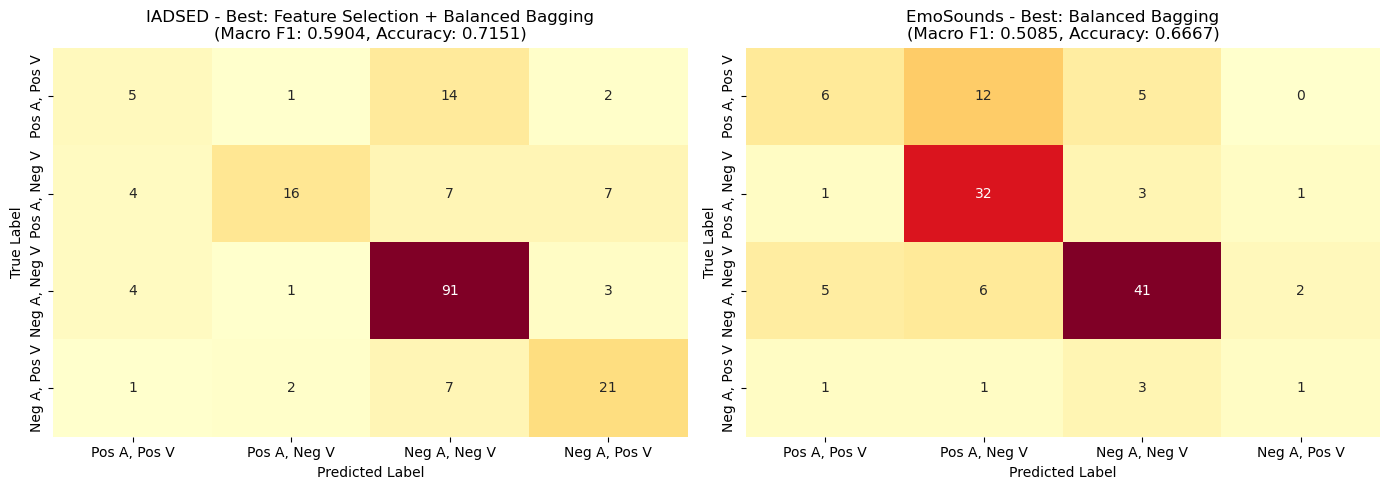

In [31]:
# Best model is chosen by highest Macro F1 Score, followed by accuracy if tied by macro f1-score.
iad_results = {
    'Baseline': (y_pred_iad_base, y_test_iad_base, accuracy_iad_base, macro_f1_iad_base),
    'Feature Selection': (y_pred_iad_fs, y_test_iad_fs, accuracy_iad_fs, macro_f1_iad_fs),
    'Balanced Bagging': (y_pred_iad_bal, y_test_iad_bal, accuracy_iad_bal, macro_f1_iad_bal),
    'Feature Selection + Balanced Bagging': (y_pred_iad_comb, y_test_iad_comb, accuracy_iad_comb, macro_f1_iad_comb)
}

emo_results = {
    'Baseline': (y_pred_emo_base, y_test_emo_base, accuracy_emo_base, macro_f1_emo_base),
    'Feature Selection': (y_pred_emo_fs, y_test_emo_fs, accuracy_emo_fs, macro_f1_emo_fs),
    'Balanced Bagging': (y_pred_emo_bal, y_test_emo_bal, accuracy_emo_bal, macro_f1_emo_bal),
    'Feature Selection + Balanced Bagging': (y_pred_emo_comb, y_test_emo_comb, accuracy_emo_comb, macro_f1_emo_comb)
}

best_iad_model = max(iad_results, key=lambda k: (iad_results[k][3], iad_results[k][2]))
best_emo_model = max(emo_results, key=lambda k: (emo_results[k][3], iad_results[k][2]))

best_iad_y_pred, best_iad_y_test, best_iad_acc, best_iad_macro_f1 = iad_results[best_iad_model]
best_emo_y_pred, best_emo_y_test, best_emo_acc, best_emo_macro_f1 = emo_results[best_emo_model]

classes = ["Pos A, Pos V", "Pos A, Neg V", "Neg A, Neg V", "Neg A, Pos V"]

fig, axes = plt.subplots(1, 2, figsize=(14,5))

cm_iad = confusion_matrix(best_iad_y_test, best_iad_y_pred)
sns.heatmap(ax=axes[0], data=cm_iad, annot=True, fmt='g', cmap='YlOrRd', cbar=False, 
            xticklabels=classes, yticklabels=classes)
axes[0].set_title(f"IADSED - Best: {best_iad_model}\n(Macro F1: {best_iad_macro_f1:.4f}, Accuracy: {best_iad_acc:.4f})")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

cm_emo = confusion_matrix(best_emo_y_test, best_emo_y_pred)
sns.heatmap(ax=axes[1], data=cm_emo, annot=True, fmt='g', cmap='YlOrRd', cbar=False, 
            xticklabels=classes, yticklabels=classes)
axes[1].set_title(f"EmoSounds - Best: {best_emo_model}\n(Macro F1: {best_emo_macro_f1:.4f}, Accuracy: {best_emo_acc:.4f})")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")


fig.tight_layout() 